## Introduction

***Objective:*** Binary Clasification of Image data. To classify an image as belonging to one of the 2 classes: Dog or Cat

***Concepts:*** Convolutional Neural Network (CNN/ConvNet) implemented using Keras API of Tensorflow

***Level***: Beginner Friendly. It consolidates all my learning from various sources. Please feel free to Upvote if this notebook helps you. Such small little things do motivate us :) I will be adding more functionality to this notebook in the future.

## Table of Contents

- [Libraries and Utilities](#lib) 
- [Define Constants](#cons)
- [Load Data](#load)
- [Data Exploration](#exp)
- [Model Training](#train)
- [Callbacks](#call)
- [Data Augmentation](#aug)
- [Fit Model](#fit)
- [Model Evaluation](#eval)
- [Misclassified Images Analysis](#miss)

## Import Libraries
<a id= "lib"> </a>

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm #to create progress bar
import os


In [93]:
df = pd.read_parquet("train.parquet.gzip").sort_values(by=["DATE"])
df[df["EVENT"].notnull()]

,P_ID,PG_ID_3,PG_ID_2,PG_ID_1,NORMAL_PRICE,L_ID,SALES_AREA,DATE,SCHOOL_HOLIDAY,EVENT,PROMOTION_TYPE,SALES_PRICE,SALES
657806,109,10,2,1,36.54,16,6874.714971,2019-10-03,0.0,German_Unity,0,36.540000,3
2170330,19,20,3,2,3.98,20,7500.402387,2019-10-03,0.0,German_Unity,0,3.980000,2
1840778,140,1,1,1,0.51,3,4678.607540,2019-10-03,0.0,German_Unity,0,0.510000,5
1081513,94,15,2,1,45.67,5,2405.373376,2019-10-03,0.0,German_Unity,0,45.670000,0
771093,189,10,2,1,0.30,3,4678.607540,2019-10-03,0.0,German_Unity,0,0.300000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572273,126,7,1,1,1.68,2,6795.995889,2022-03-13,0.0,Local_Holiday_0,0,1.680000,2
1544972,73,14,2,1,3.09,4,1228.477201,2022-03-13,0.0,Local_Holiday_0,0,3.090000,0
852186,76,17,3,2,21.48,3,4678.607540,2022-03-13,0.0,Local_Holiday_0,1,10.910098,1
818672,122,3,1,1,4.76,1,3436.702058,2022-03-13,0.0,Local_Holiday_0,0,4.760000,8


### Description of variables

P_ID  
Identifier of the different products/articles.

L_ID  
Identifier of the different locations/stores.

DATE  
Date of the data of the given record. Together with P_ID and L_ID, uniquely identifies each record.

SALES  
Aggregated daily sales of the given product in the given location at the given date.

PG_ID_1  
Identifier of the highest level of the product group hierarchy, e.g., food or beverages.

PG_ID_2  
Identifier of the second highest level of the product group hierarchy, e.g., sweets or vegetables.

PG_ID_3  
Identifier of the lowest level of the product group hierarchy, e.g., apples or bananas.

NORMAL_PRICE  
Usual, unreduced price of the product-location-date combination at hand. Not necessarily the actual sales price (in case of a price reduction).

SALES_PRICE  
Actual, potentially reduced, price of the product-location-date combination at hand.

PROMOTION_TYPE  
Values indicating no promotion (0) or two different typess of promotions (1 and 2) for the product-location-date combination at hand.

SALES_AREA  
Size of the given store in square meters.

EVENT  
Name of a holiday occuring on the given date in the region of the given location.
  
SCHOOL_HOLIDAY  
Boolean flag indicating if the given date is a school holiday in the region of the given location.

In [47]:
print(len(df[df.P_ID == 1]))
print(len(df))
print(df.dtypes)

17342
2671227
P_ID                       int64
PG_ID_3                    int64
PG_ID_2                    int64
PG_ID_1                    int64
NORMAL_PRICE             float64
L_ID                       int64
SALES_AREA               float64
DATE              datetime64[ns]
SCHOOL_HOLIDAY           float64
EVENT                     object
PROMOTION_TYPE             int16
SALES_PRICE              float64
SALES                      int64
dtype: object


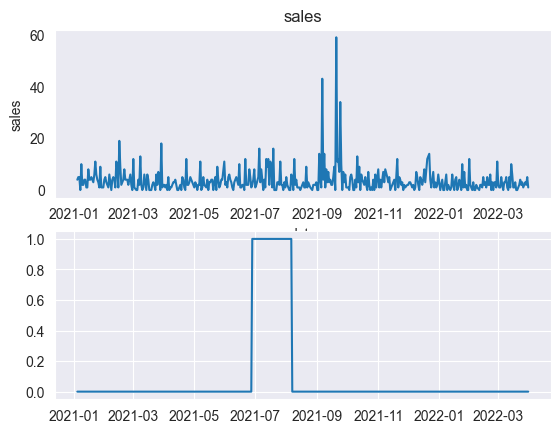

In [91]:
data = df[(df.DATE > "2021-01-03") & (df.DATE < "2022-04-25") & (df.P_ID == 2) & (df.L_ID == 11)].sort_values(by=["DATE"])
#data = df[(df.DATE > "2021-01-03") & (df.DATE < "2022-04-25") & (df.L_ID == 11)].groupby([]).sort_values(by=["DATE"])

fig, ax = plt.subplots(2)

ax[0].plot(data["DATE"], data["SALES"])
ax[0].set(xlabel='date', ylabel='sales',
       title='sales')

ax[0].grid()

ax[1].plot(data["DATE"], data["SCHOOL_HOLIDAY"])


plt.show()

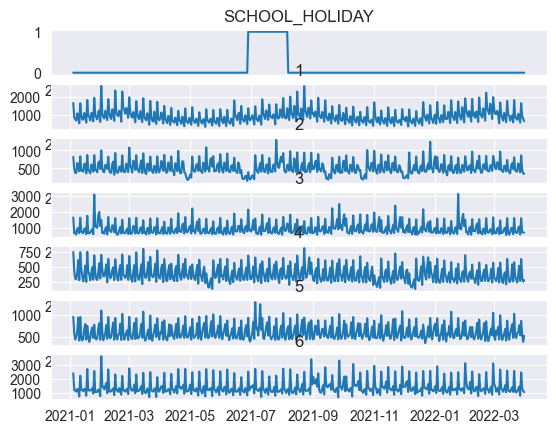

In [100]:
def aggSalesPerGroup(df, groupKey = 'PG_ID_2', groupId = 1):
    return df[(df[groupKey] == groupId)].groupby(["DATE"], as_index=False)["SALES"].sum()

data = df[(df.DATE > "2021-01-03") & (df.DATE < "2022-04-25")]

groups = [1,2,3,4,5,6]

fig, ax = plt.subplots(len(groups)+1)

ax[0].grid()
ax[0].plot(data["DATE"], data["SCHOOL_HOLIDAY"])
ax[0].set(title='SCHOOL_HOLIDAY')

for i, groupId in enumerate(groups):
    agg = aggSalesPerGroup(data, 'PG_ID_3', groupId)
    ax[i+1].plot(agg["DATE"], agg["SALES"])
    ax[i+1].set(title=groupId)

plt.show()


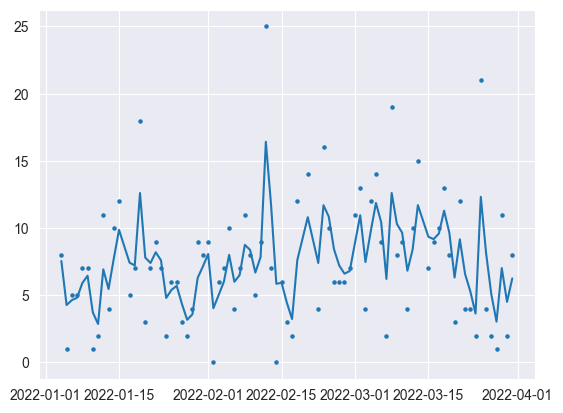

In [124]:
df["ewm"] = df.groupby(['P_ID', 'L_ID'], sort=False)['SALES'].transform(lambda x: x.ewm(halflife=1).mean()).values

fig, ax = plt.subplots()
plot_data = df[(df.P_ID == 1) & (df.L_ID == 1) & (df.DATE > "2022-01-03") & (df.DATE < "2022-04-25")]
ax.scatter(plot_data["DATE"], plot_data["SALES"], s=5)
ax.plot(plot_data["DATE"], plot_data["ewm"])
# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

## Define Constants
<a id= "cons"> </a>

In [66]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # 3 for Colored Images and 1 for Grayscale Images
BATCH_SIZE=32
EPOCHS=40

if FAST_RUN:
    EPOCHS= 5 

In [67]:
class_names = ['issue', 'ok']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
class_label_to_name =  {i:class_name for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

In [68]:
class_names_label

{'issue': 0, 'ok': 1}

## Load Data
<a id= "load"> </a>

In [69]:
def load_data():

    datasets = [DATASET_PATH + '/train', DATASET_PATH + '/test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)   

        output.append((images, labels))
    

    return output

In [70]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../../../imgs/pallet/dataset_003/train


100%|██████████| 1121/1121 [00:00<00:00, 4904.76it/s]


Loading ../../../imgs/pallet/dataset_003/test


100%|██████████| 283/283 [00:00<00:00, 4920.77it/s]


The data contains consecutive images of dogs followed by images of cats together. Let us shuffle it.

In [71]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Explore Data
<a id= "exp"> </a>

Let us get the length of each dataset, counts across all categories etc.

In [72]:
print(train_labels.shape[0])
print(test_labels.shape[0])

2478
622


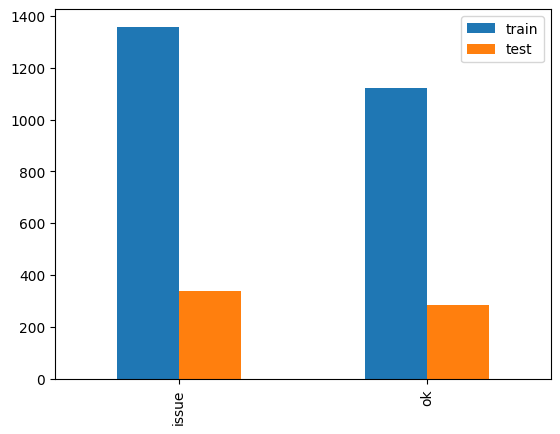

In [73]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Plot Sample Image

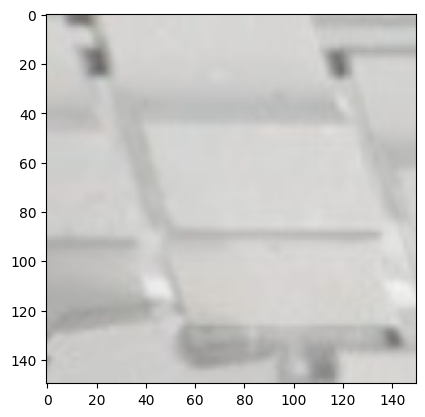

In [11]:
plt.imshow(random.choice(train_images))

### Some data-format related changes to make datasets comptabile with Keras

Using the method to_categorical(), `train_labels` which has categories represented by integers (1 for Dog, 0 for Cat) is converted into a matrix (eg for Dog: [0,1] and for Cat: [1,0]).<br>
Output: 
This function returns a matrix of binary values (either ‘1’ or ‘0’). It has number of rows equal to the length of the input vector and number of columns equal to the number of classes.

In [12]:
train_labels=to_categorical(train_labels,len(class_names))
test_labels=to_categorical(test_labels,len(class_names))

In [13]:
train_labels[0:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [14]:
train_images.shape

(2580, 150, 150, 3)

train_images is already in Keras accepted format (number_of_images, image width, image height, channels). So we do not need to do reshape it again. <br>
p.s. if number of images is unknown during the reshape operation for number_of_images parameter, put `-1` instead.

In [15]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
#train_images = train_images.reshape(-1,IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)
#test_images = test_images.reshape(-1,IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)

## Model Training
<a id= "train"> </a>

**Layers**<br>
In Keras Sequential API, we add one layer at a time, starting from the input layer.
- **Conv2D:** 2D convolution layer. When using this layer as the first layer in a model, provide the keyword argument input_shape, e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last". You can use None when a dimension has variable size.<br>
Other key arguments are `filters` and `kernel_size`. filters is the number of desired feature maps. kernel_size is the size of the convolution window. It can be an integer or tuple/list of 2 integers (eg 5 or (5,5) mean the same thing for kernel_size). This layer extracts features from an image (eg ear shape, eyes shape etc in case of a Cat image). 
- **MaxPooling2D:** Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by `strides` along each dimension.
- **Flatten:** Flattens the input, that is converts the final feature maps into a one single 1D vector.. Does not affect the batch size.
- **Dense:** Just your regular densely-connected NN layer.
- **Dropout:** This layer is used for Regularization. It randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. <br>
rate: Float between 0 and 1. Fraction of the input units to drop.
- **BatchNormalization:** Layer that normalizes its inputs. Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

**Activation Functions:**

- **Relu:** 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. Given a value x, returns max(x, 0).

- **Softmax:** 2 neurons, probability that the image belongs to one of the two classes. Softmax converts a vector of values to a probability distribution. The elements of the output vector are in range (0, 1) and sum to 1. Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution.

**Loss and Optimizer**<br>
- Binary Cross Entropy computes the cross-entropy loss between true labels and predicted labels. Use this cross-entropy loss for binary (0 or 1) classification applications. Since we have only 2 classes, we used `binary_crossentropy`
- CategoricalCrossentropy: Use this crossentropy loss function when there are two or more label classes. The labels are expected to be provided in a one_hot representation. If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss.
- RMSprop: The gist of RMSprop is to: Maintain a moving (discounted) average of the square of gradients, Divide the gradient by the root of this average. For our project, we have used `rmsprop` optimizer. Feel free to apply adam or other optimizers and see if it improves the performance of the model.
- adam: Another popular optimizer is adam. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='binary_crossentropy', optimizer="rmsprop",metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

## Callbacks
<a id= "call"> </a>

**Early Stopping**

To prevent over fitting we will stop the learning after val_loss value has not decreased for 10 epochs

In [17]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction** <br>
tl;dr: We will reduce the Learning Rate when Accuracy does not increase for 2 steps. <br>
The Learning Rate (LR) is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

It is better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. To keep the advantage of the fast computation time with a high LR, we will decrease the LR dynamically every X steps (epochs) depending on if it is necessary (when accuracy does not improve).

With the ReduceLROnPlateau function from Keras.callbacks, we will reduce the LR by `factor` (0.1 in this case) if the accuracy does not improve after 2 epochs.


In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

## Data Augmentation to Prevent Overfitting
<a id= "aug"> </a>

Data Augmentation is done to prevent overfitting by exposing the images to random changes like Resizing, Flips, Rotation etc. This is what happens during Augmentation:
- A batch of images is taken for training. 
- The Generator applies random transformations to each image in the batch during Training.
- Replacing the original batch of images with a new randomly transformed batch.
- During each Epoch, a random variation of the augmented image is used for training.<br><br>
Key Points:
- The overall number of sample size does not increase or decrease due to Data Augmentation
- Augmentation prevents model from generalising. Instead of learning too much from an image, it learns from an augmented transformation in each epoch
- `flow()` , `flow_from_directory()`, `flow_from_dataframe()` : One of these three functions can be used to transform Images. When there are separate subfolders for each category (eg cat images in Cat folder, and Dog images in Dog folder), then we use `flow_from_directory()`. If there is a single folder which contains all the images, then we can use `flow_from_dataframe()`. 
- `fit()` :Fits the data generator to some sample data. This computes the internal data stats related to the data-dependent transformations, based on an array of sample data. Only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True. When rescale is set to a value, rescaling is applied to sample data before computing the internal data stats.
- Data Augmentation techniques are applied only to the data we train the model on (train_images), we do not apply it on test dataset (test_images) or validation dataset (in case there are 3 sets).

**Training Generator**

For Training Images, we will apply following augmentations:

- Randomly rotate some training images by 15 degrees
- Randomly Zoom by 20% some training images
- Horizontally flip images 
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    width_shift_range=0,
    height_shift_range=0
)

train_generator= train_datagen.flow(
    train_images, 
    train_labels,
    batch_size= BATCH_SIZE)

**Validation Generator**

For Validation images, we will only apply Normalization. <br>
Normalization ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. <br>
A good read to understand the importance of Image Normalization:<br>
https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator= test_datagen.flow(test_images, test_labels,batch_size= BATCH_SIZE)


## Check Sample Image after augmentation

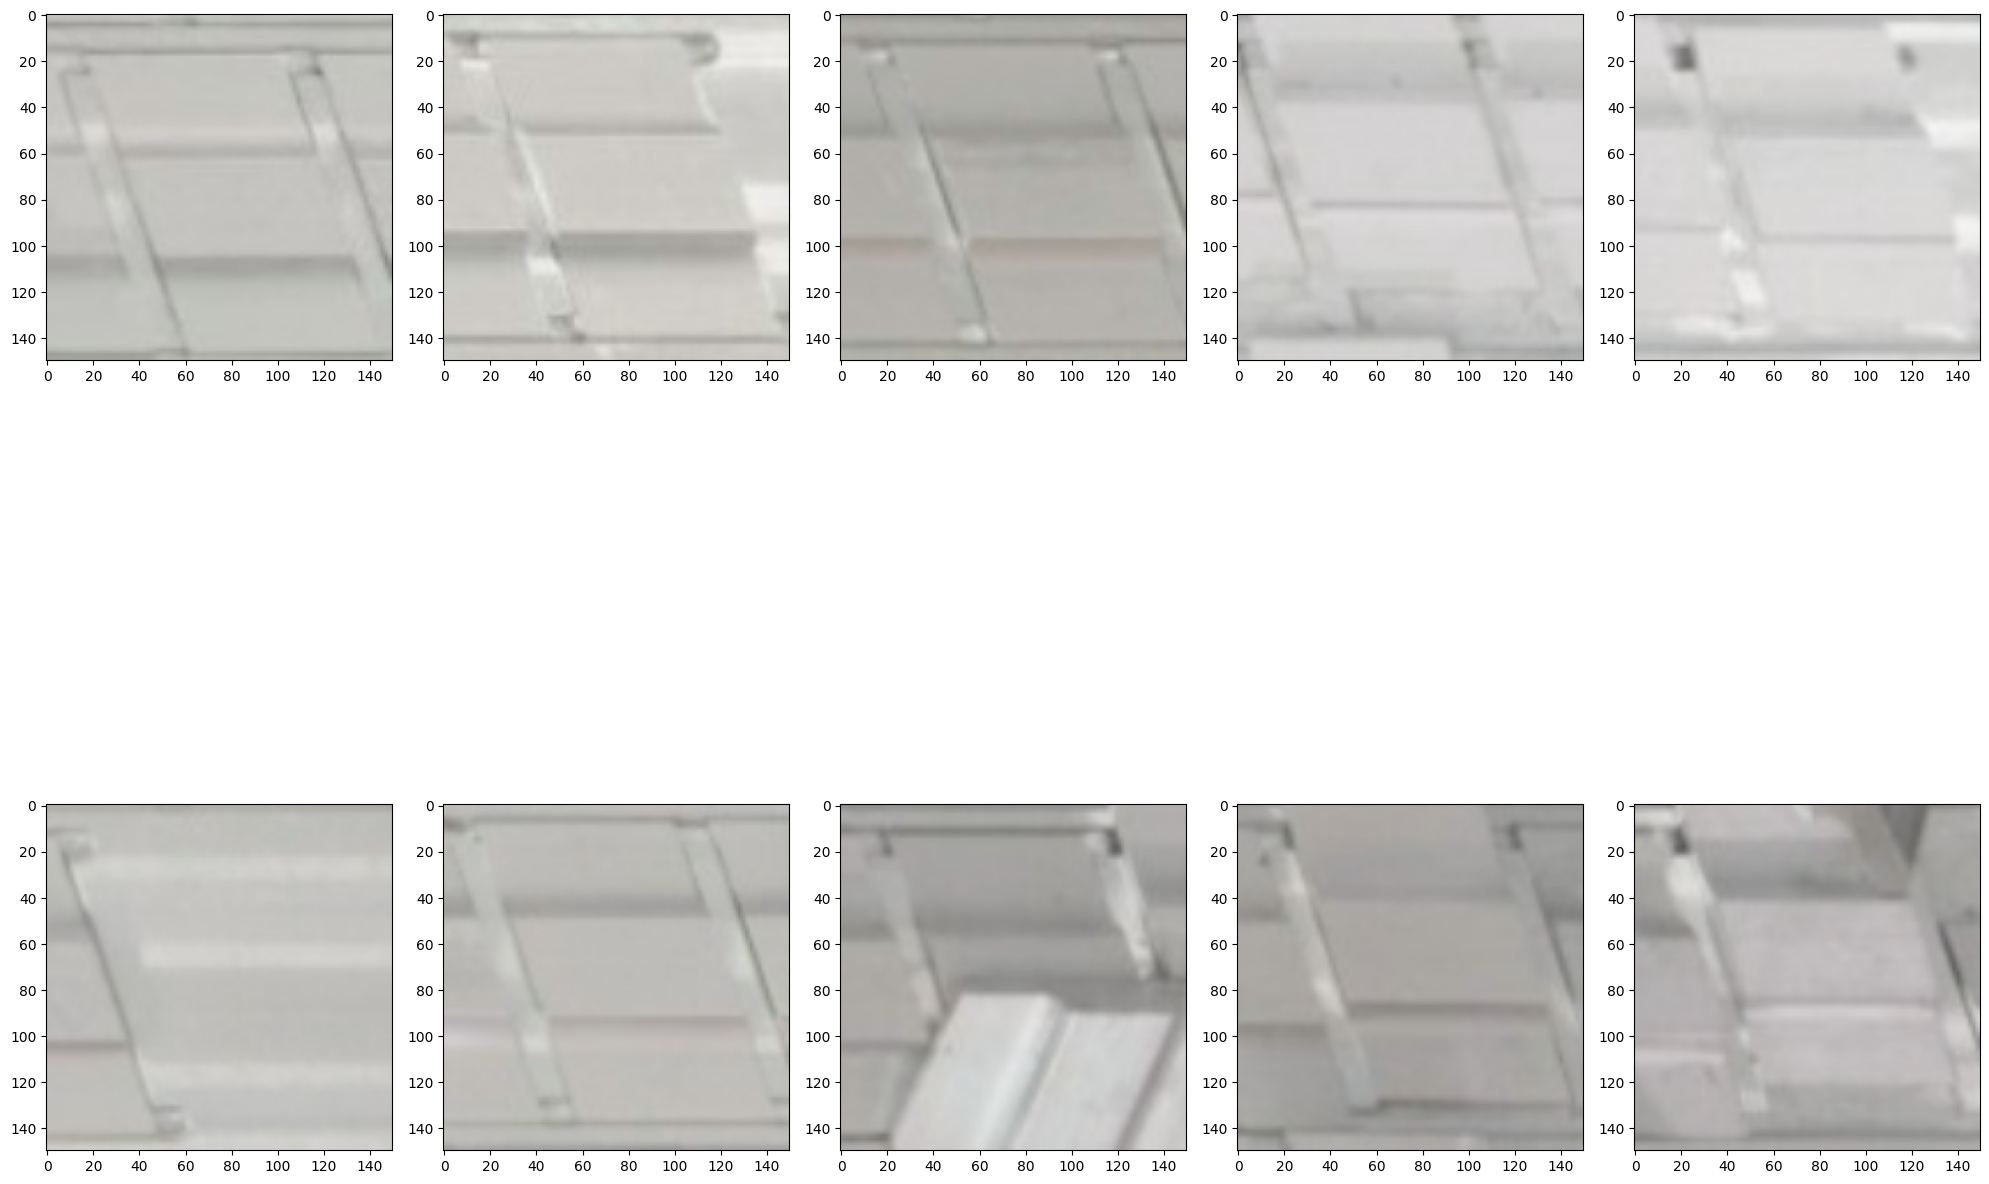

In [34]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

augmented_images = [train_generator[0][0][i] for i in range(10)]
plotImages(augmented_images)

## Fit Model
<a id= "fit"> </a>

- When using Generator for inputs, we do not need to specify (train_X, train_Y) separately. The model will automatically take train_Y from Generator objects. It aplies for both training and validation datasets. If we are not using Generator or Dataframe, then we need to supply input in the form (train_X, train_Y)
- steps_per_epoch: Integer or None. Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
- If input to fit() is generator, then we cannot use validation_split. Therefore, we need to have separate train and validation sets for the CNN fit() method which we can achieve either by reading train-test datasets from separate directories (like in our case) or using sklearn train_test_split method. 

In [23]:
%%time
hist = model.fit(train_generator,
    epochs=EPOCHS,
    validation_data= test_generator,
    steps_per_epoch=train_images.shape[0]/BATCH_SIZE,
    callbacks=callbacks 
) 

Epoch 1/35
80/80 [==============================] - 18s 210ms/step - loss: 0.7220 - accuracy: 0.6426 - val_loss: 0.6026 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 2/35
80/80 [==============================] - 16s 203ms/step - loss: 0.6940 - accuracy: 0.6527 - val_loss: 0.5227 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 3/35
80/80 [==============================] - 17s 206ms/step - loss: 0.5967 - accuracy: 0.6713 - val_loss: 0.3908 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 4/35
80/80 [==============================] - 17s 206ms/step - loss: 0.4352 - accuracy: 0.8008 - val_loss: 0.3753 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 5/35
80/80 [==============================] - 16s 202ms/step - loss: 0.3615 - accuracy: 0.8469 - val_loss: 0.2409 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 6/35
80/80 [==============================] - 16s 203ms/step - loss: 0.2979 - accuracy: 0.8756 - val_loss: 0.1817 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 7/35
80/80 [==============================] - 16s 203ms/st

### Save the Model

In [24]:
model.save('keras_30.h5')

#Load Model
#model3= keras.models.load_model("../input/model-v3/keras_30.h5")

## Model Evaluation
<a id= "eval"> </a>

In [25]:
test_loss = model.evaluate(test_images, test_labels)

36/36 [==============================] - 2s 42ms/step - loss: 5.7579 - accuracy: 0.9788


Plotting Loss and Accuracy graphs for Training and Validation datasets

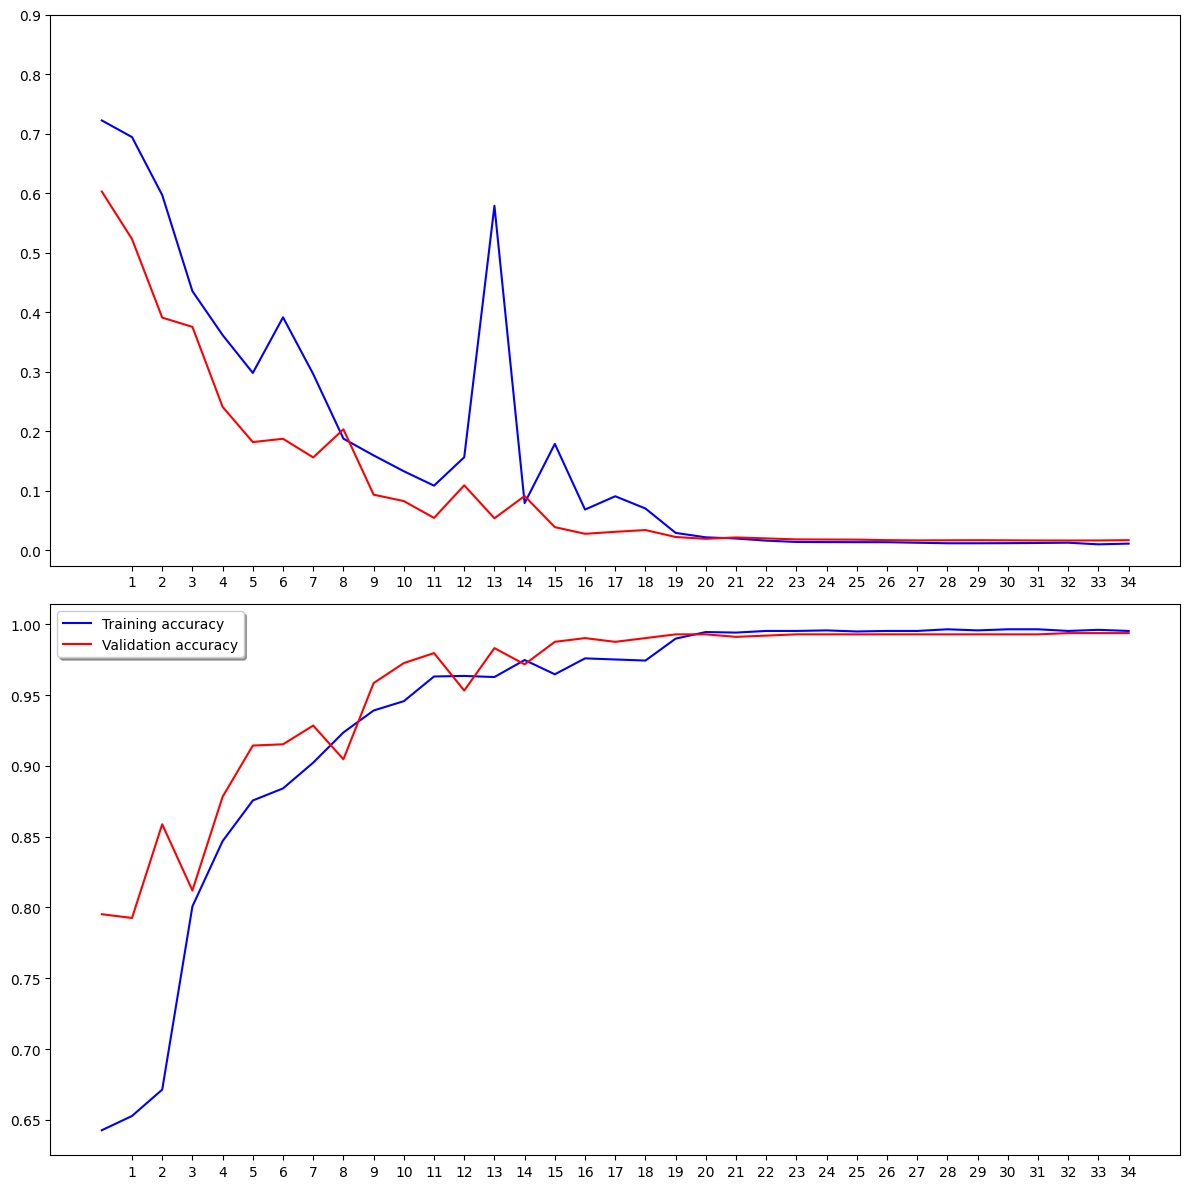

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


## Making Predictions

In [27]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

36/36 [==============================] - 2s 42ms/step


In [28]:
#Reverse conversion from to_categorical
test_labels_vector = np.argmax(test_labels, axis = 1)

### Confusion Matrix

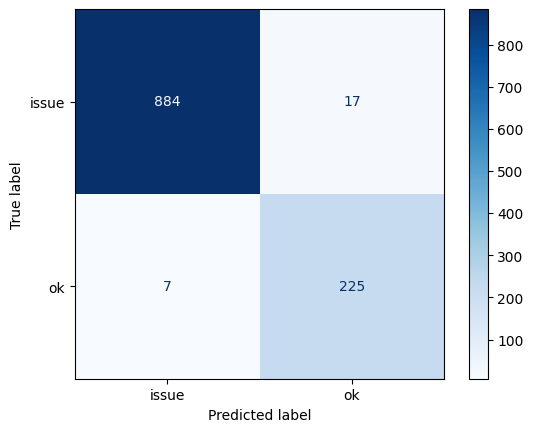

In [29]:
cm = confusion_matrix(test_labels_vector, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Classification Report

In [30]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_vector, pred_labels, target_names = class_names))

              precision    recall  f1-score   support

       issue       0.99      0.98      0.99       901
          ok       0.93      0.97      0.95       232

    accuracy                           0.98      1133
   macro avg       0.96      0.98      0.97      1133
weighted avg       0.98      0.98      0.98      1133



## Misclassified Images
<a id= "miss"> </a>

Which Images did the algorithm classify incorrectly? Is there a pattern? Does the algorithm work better for some categories than other? Let us analyse some of these questions.

In [31]:
def classification_evaluation(classification, predicted_labels, test_labels, test_images):
    if classification== "correct":
        indices_list = np.where(predicted_labels == test_labels)[0]
    else:
        indices_list = np.where(predicted_labels!= test_labels)[0]
    test_images_filtered= [test_images[i] for i in indices_list]
    images_labels_original= [test_labels[i] for i in indices_list]
    images_labels_predicted= [pred_labels[i] for i in indices_list]
    print(f"{len(test_images_filtered)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(images_labels_original, return_counts=True)
    for i in range(0,len(unique)):
        print(f"for category {class_label_to_name[unique[i]]}\n    the number of {classification.upper()} classified images were: {counts[i]}")
        
    # Plot some of the misclassified images
    print("\n\n")
    fig,ax=plt.subplots(5,len(class_names))
    fig.suptitle(f"Sample of {classification.upper()} Classified Images", fontsize=20)
    fig.set_size_inches(15,15)
    for i in range(5):
        for j in range (len(class_names)):
            l=random.randint(0,len(test_images_filtered)-1)
            ax[i,j].imshow(test_images_filtered[l])
            ax[i,j].set_title("Predicted: "+str(class_label_to_name[images_labels_predicted[l]])+"\n"+"Actual: "+str(class_label_to_name[images_labels_original[l]]))
    plt.tight_layout()

24 images were classified INCORRECT out of a total of 1133 in the Test dataset
for category issue
    the number of INCORRECT classified images were: 17
for category ok
    the number of INCORRECT classified images were: 7





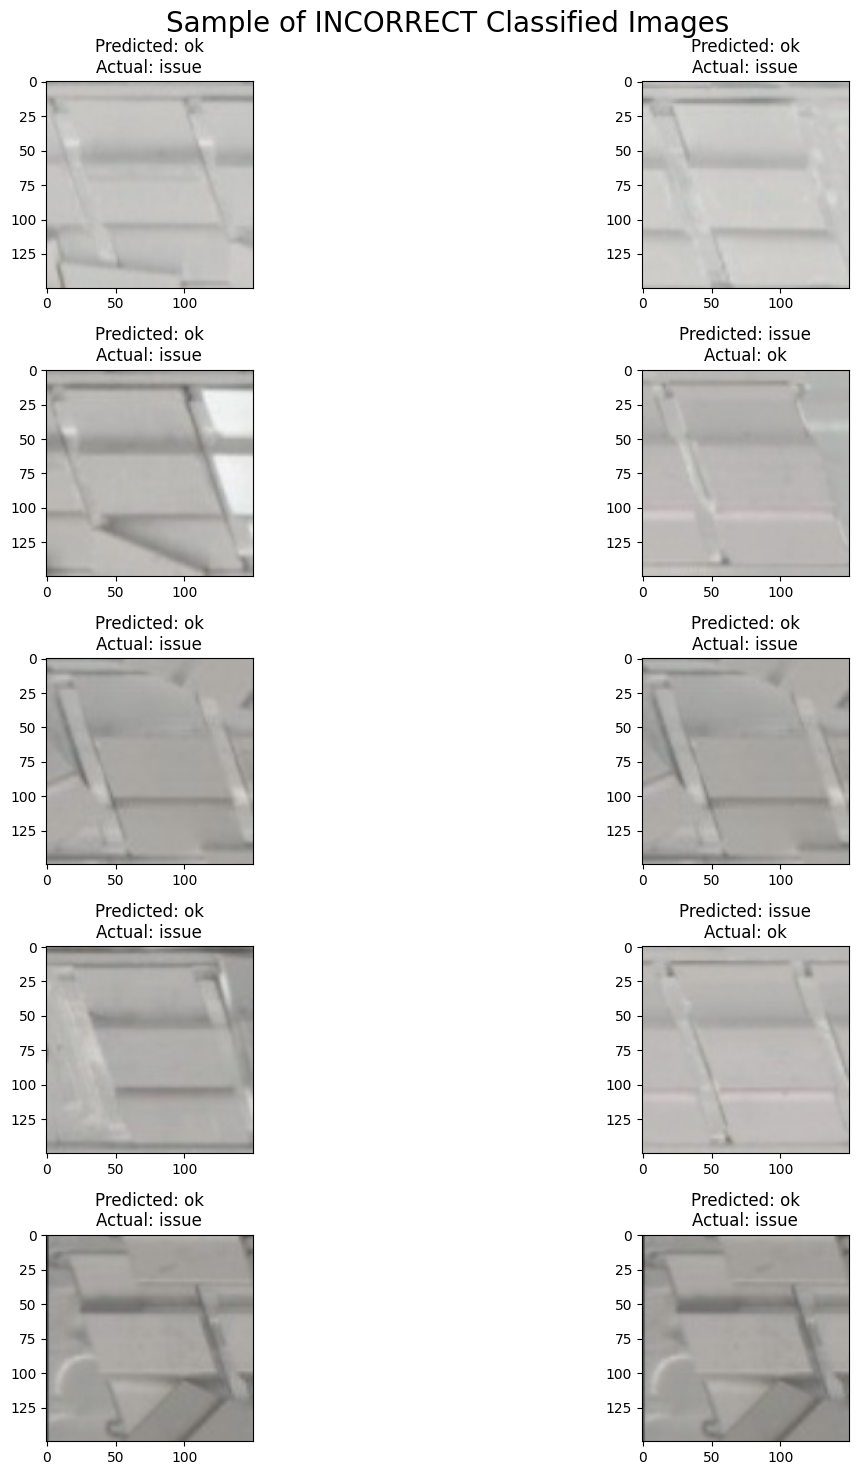

In [32]:
classification_evaluation("incorrect", pred_labels, test_labels_vector, test_images)

## Correctly Classified Images

Let us also look at some of the Images which the algorithm classified correctly :)

1109 images were classified CORRECT out of a total of 1133 in the Test dataset
for category issue
    the number of CORRECT classified images were: 884
for category ok
    the number of CORRECT classified images were: 225





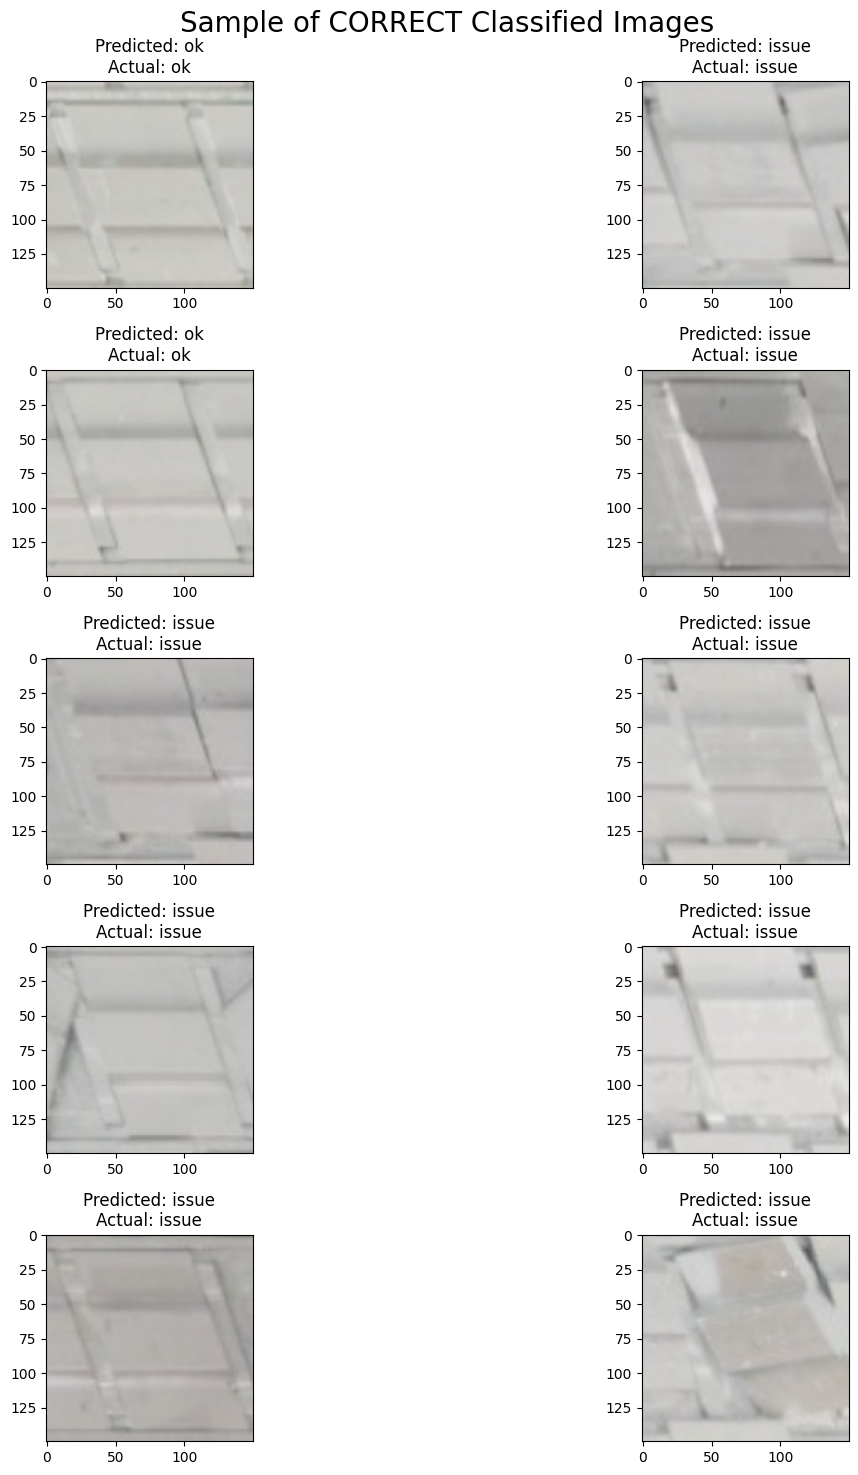

In [33]:
classification_evaluation("correct", pred_labels, test_labels_vector, test_images)

**Parameters to experiment with for future Runs:**
- Image size
- Batch size
- Learning Rate/ Callbacks
- Data augmentation options
- With and without Normalization
- CNN Architecture itself (different combinations of Layers)
- Number of Epochs
- Compiler Optimizer algorithm
- Transfer Learning

   **Some of the places from where I learnt CNN which made this notebook possible:**<br>
https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 <br>
https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification <br>
https://www.kaggle.com/code/rajmehra03/flower-recognition-cnn-keras <br>
https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras/notebook <br>
https://www.geeksforgeeks.org/ <br>
